C:\Users\Ratul Sarker\AppData\Local\Temp\ipykernel_2028\4137144729.py:4: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books_df = pd.read_csv('Books.csv')


<Axes: >

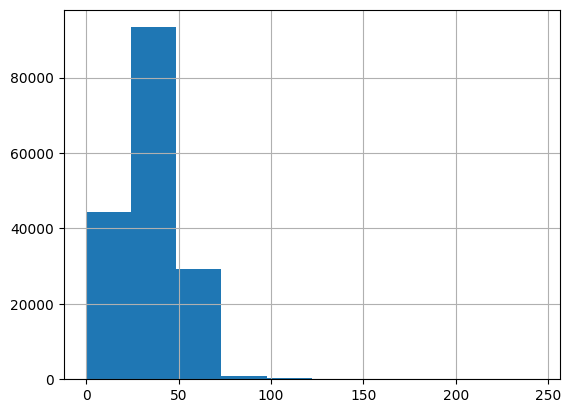

In [9]:
import pandas as pd

# Load the datasets
books_df = pd.read_csv('Books.csv')
ratings_df = pd.read_csv('Ratings.csv')
users_df = pd.read_csv('Users.csv')

#----------------------Data Cleaning----------------------#
# filter out books with less than 1 ratings
ratings_df = ratings_df[ratings_df['Book-Rating'] > 0]

# Example for handling missing values
books_df.dropna(inplace=True)  # This drops rows with any missing value
# Example for data type conversion
users_df['Age'] = pd.to_numeric(users_df['Age'], errors='coerce')

# Example EDA
ratings_df['Book-Rating'].describe()
users_df['Age'].hist()



In [4]:
# Data Cleaning for Books DataFrame
# Convert 'Year-Of-Publication' to numeric, setting errors='coerce' which replaces invalid values with NaN
books_df['Year-Of-Publication'] = pd.to_numeric(books_df['Year-Of-Publication'], errors='coerce')

# Check for missing values in all dataframes
print("\nMissing values in Books DataFrame:")
print(books_df.isnull().sum())
print("\nMissing values in Users DataFrame:")
print(users_df.isnull().sum())
print("\nMissing values in Ratings DataFrame:")
print(ratings_df.isnull().sum())



Missing values in Books DataFrame:
ISBN                   0
Book-Title             0
Book-Author            2
Year-Of-Publication    3
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64

Missing values in Users DataFrame:
User-ID          0
Location         0
Age         110762
dtype: int64

Missing values in Ratings DataFrame:
User-ID        0
ISBN           0
Book-Rating    0
dtype: int64


In [10]:
# Handling missing values in Books DataFrame
books_df.dropna(subset=['Book-Author', 'Publisher', 'Year-Of-Publication'], inplace=True)

# Optionally, dropping image URL columns as they are not needed for the recommendation system
books_df.drop(columns=['Image-URL-S', 'Image-URL-M', 'Image-URL-L'], inplace=True)

# Handling missing values in Users DataFrame
# Option 1: Fill missing ages with the median age
users_df['Age'].fillna(users_df['Age'].median(), inplace=True)

# Display the updated dataframes
print("Updated Books DataFrame:")
print(books_df.head())
print("\nUpdated Users DataFrame:")
print(users_df.head())





Updated Books DataFrame:
         ISBN                                         Book-Title  \
0  0195153448                                Classical Mythology   
1  0002005018                                       Clara Callan   
2  0060973129                               Decision in Normandy   
3  0374157065  Flu: The Story of the Great Influenza Pandemic...   
4  0393045218                             The Mummies of Urumchi   

            Book-Author Year-Of-Publication                   Publisher  
0    Mark P. O. Morford                2002     Oxford University Press  
1  Richard Bruce Wright                2001       HarperFlamingo Canada  
2          Carlo D'Este                1991             HarperPerennial  
3      Gina Bari Kolata                1999        Farrar Straus Giroux  
4       E. J. W. Barber                1999  W. W. Norton &amp; Company  

Updated Users DataFrame:
   User-ID                            Location   Age
0        1                  nyc, new york, 

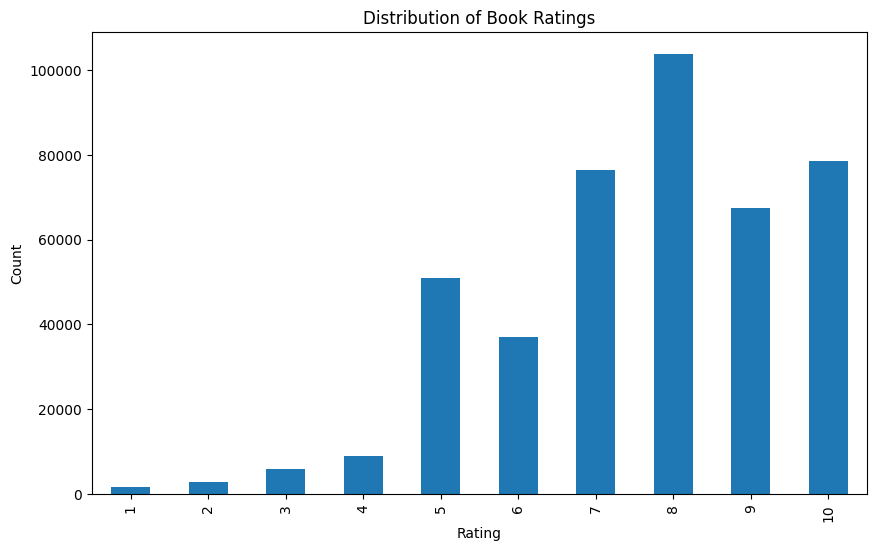

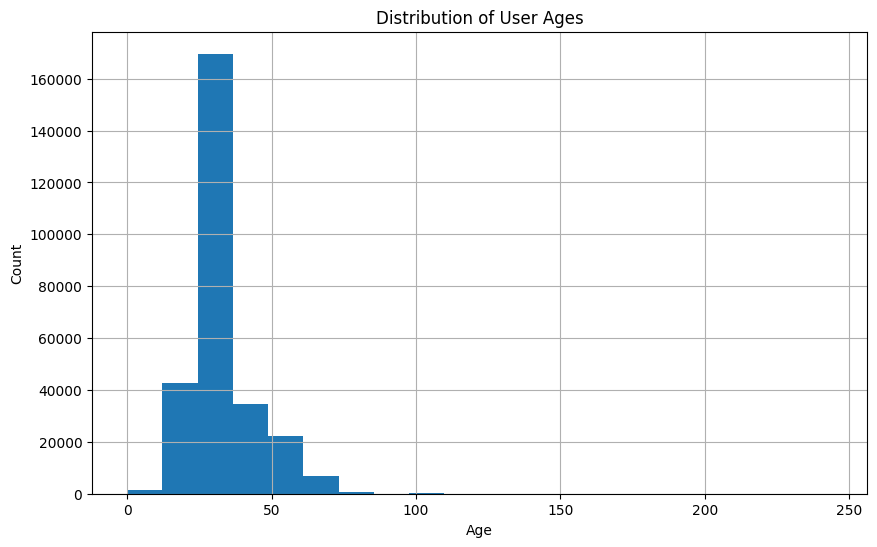

Range of Publication Years: 0 to 2050
Number of Unique Authors: 102019
Number of Unique Publishers: 16803
Range of Publication Years: 0 to 2050


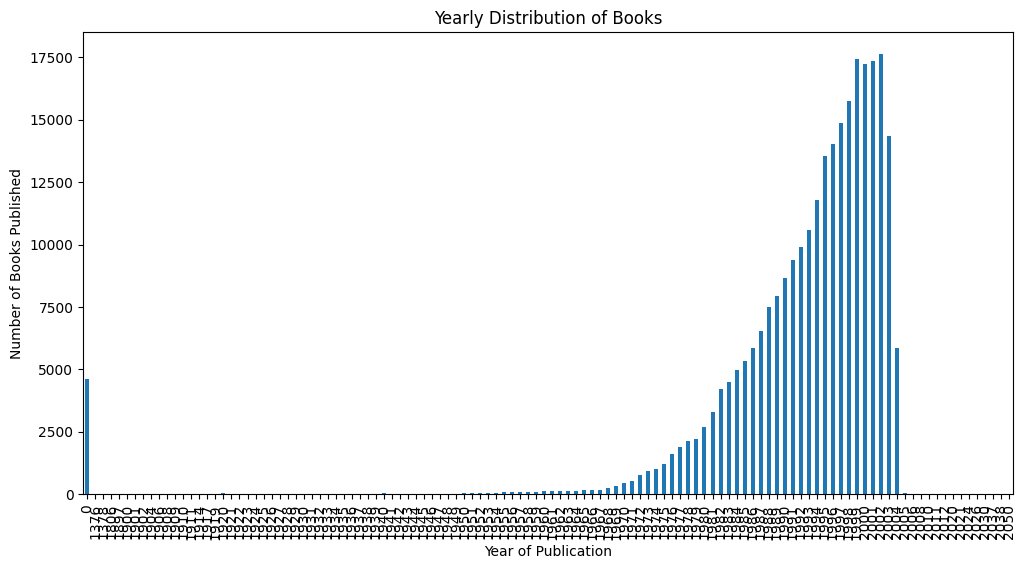

In [15]:
import matplotlib.pyplot as plt

# Rating Distribution
plt.figure(figsize=(10, 6))
ratings_df['Book-Rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Book Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

# User Age Distribution
plt.figure(figsize=(10, 6))
users_df['Age'].hist(bins=20)
plt.title('Distribution of User Ages')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

# Convert 'Year-Of-Publication' to numeric, setting errors to 'coerce' which replaces non-numeric values with NaN
books_df['Year-Of-Publication'] = pd.to_numeric(books_df['Year-Of-Publication'], errors='coerce')

# Drop rows with NaN in 'Year-Of-Publication'
books_df.dropna(subset=['Year-Of-Publication'], inplace=True)

# Find the min and max of publication years
min_year = books_df['Year-Of-Publication'].min()
max_year = books_df['Year-Of-Publication'].max()

print(f'Range of Publication Years: {min_year} to {max_year}')


# Book Metadata Analysis
unique_authors = books_df['Book-Author'].nunique()
unique_publishers = books_df['Publisher'].nunique()
publication_years = books_df['Year-Of-Publication'].unique()

print(f'Number of Unique Authors: {unique_authors}')
print(f'Number of Unique Publishers: {unique_publishers}')
print(f'Range of Publication Years: {publication_years.min()} to {publication_years.max()}')
# Create a plot for yearly distribution
books_df['Year-Of-Publication'].value_counts().sort_index().plot(kind='bar', figsize=(12, 6))

plt.title('Yearly Distribution of Books')
plt.xlabel('Year of Publication')
plt.ylabel('Number of Books Published')
plt.show()


In [19]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split


# Reindex User IDs and ISBNs
user_id_mapping = {id: i for i, id in enumerate(ratings_df['User-ID'].unique())}
isbn_mapping = {isbn: i for i, isbn in enumerate(books_df['ISBN'].unique())}
ratings_df['User-ID'] = ratings_df['User-ID'].map(user_id_mapping)
ratings_df['ISBN'] = ratings_df['ISBN'].map(isbn_mapping)

# Creating the user-item matrix
user_item_matrix = ratings_df.pivot(index='User-ID', columns='ISBN', values='Book-Rating').fillna(0)

# Compute the cosine similarity matrix for users
user_similarity = cosine_similarity(user_item_matrix)
user_similarity_df = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)

# Encode 'Book-Author' using TF-IDF
tfidf = TfidfVectorizer(stop_words='english')
author_matrix = tfidf.fit_transform(books_df.loc[books_df['ISBN'].isin(isbn_mapping.keys()), 'Book-Author'])

# Predict ratings function
def predict_ratings(user_id, user_similarity_df, user_item_matrix, n_neighbors=5):
    similar_users = user_similarity_df.loc[user_id].sort_values(ascending=False)[1:n_neighbors+1].index
    user_ratings = user_item_matrix.loc[similar_users].mean()
    return user_ratings

# Recommend books based on content function
def recommend_books_based_on_content(book_id, author_matrix, top_n=5):
    book_index = list(isbn_mapping.values()).index(book_id)
    book_similarities = cosine_similarity(author_matrix[book_index], author_matrix)
    similar_books = books_df.iloc[book_similarities.argsort()[0][-top_n-1:-1]].copy()
    return similar_books

# Hybrid recommendation function
def hybrid_recommendation(user_id, book_id, weights=(0.5, 0.5)):
    if sum(weights) != 1:
        raise ValueError("Weights must sum up to 1.")

    collab_predictions = predict_ratings(user_id, user_similarity_df, user_item_matrix)
    content_recommendations = recommend_books_based_on_content(book_id, author_matrix)

    collab_recommended_books = collab_predictions.sort_values(ascending=False).index
    content_recommended_books = content_recommendations['ISBN']

    combined_recommendations = list(set(collab_recommended_books) & set(content_recommended_books))
    if not combined_recommendations:
        combined_recommendations = list(collab_recommended_books[:5]) + list(content_recommended_books[:5])

    return combined_recommendations

# Splitting the data
train_data, test_data = train_test_split(ratings_df, test_size=0.2)

# Testing the model (use actual user and book IDs)
# test_user_id = ...
# test_book_id = ...
# recommendations = hybrid_recommendation(test_user_id, test_book_id)
# print("Recommended Books:", recommendations)
# Select a user and a book for testing
test_user_id = list(user_id_mapping.values())[0]  # First user in the mapping
test_book_id = list(isbn_mapping.values())[0]  # First book in the mapping

# Get recommendations using the hybrid recommendation system
recommendations = hybrid_recommendation(test_user_id, test_book_id)

# Translate the recommended book indices back to ISBNs
recommended_isbns = [list(isbn_mapping.keys())[list(isbn_mapping.values()).index(book_id)] for book_id in recommendations]

# Print the recommended book ISBNs
print("Recommended Books (ISBNs):", recommended_isbns)


ValueError: Index contains duplicate entries, cannot reshape